<a href="https://colab.research.google.com/github/Qwerty71/tiramisuBackgroundRemover/blob/master/Tiramisu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Background Removal with the One-Hundred Layers Tiramisu Model**


---

Background removal is a very useful form of machine learning. Over the years, there have been many models created to try and improve on this task. Today, we will look at the Tiramisu Model, and implement it in Keras.

### **What is the Tiramisu Model?**

The Tiramisu Model (also known as the One-Hundred layer Tiramisu Model), is a deep convolutional neural network composed of 103 layers (contrary to the name), created by the researchers in [this paper](https://arxiv.org/pdf/1611.09326.pdf). It is often used for image segmentation, and in this application we will use it to separate a pet from the background.

Before we get into building this model, let's load our libraries.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
import datetime

TensorFlow 2.x selected.


We will be using the Oxford Pet dataset to train. It consists of images, labels representing which type of cat/dog the pet is (will not be used in this background removal task), and a segmentation mask which separates the pet from the background. The mask is a set of pixels where each pixel is a 1, 2, or 3 - a 1 represents a pixel within the object, a 2 represents a pixel bordering the object, and a 3 represents a pixel without the object. Since we have concrete outputs, our problem here is a classification problem.

Thankfully, TensorFlow Datasets already has this dataset in its library, so we will simply load it from there.

In [2]:
data = tfds.load('oxford_iiit_pet:3.*.*')

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteBRMODT/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteBRMODT/oxford_iiit_pet-test.tfrecord



Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0. Subsequent calls will reuse this data.


Let's also normalize the data. The following code resizes the images and masks to be `64x64` rather than `128x128` (as that would be too computationally expensive, and outside the hardware capability of Google Colab), normalizes the images to be between ```[0, 1]``` by dividing by 255, and the masks to be values in the set of `{0, 1, 2}` by subtracting 1.

In [0]:
size = 64

def normalizeImage(image):
  return tf.cast(image, tf.float32) / 255

def normalizeMask(mask):
  return mask - 1

def generateData(dataset):
  x_train, y_train, x_test, y_test = [], [], [], []
  for example in dataset['train']:
    x_train.append(normalizeImage(tf.image.resize(example['image'], (size, size))).numpy())
    y_train.append(normalizeMask(tf.image.resize(example['segmentation_mask'], (size, size))).numpy())
  for example in dataset['test']:
    x_test.append(normalizeImage(tf.image.resize(example['image'], (size, size))).numpy())
    y_test.append(normalizeMask(tf.image.resize(example['segmentation_mask'], (size, size))).numpy())
  return [np.array(x_train), np.array(x_test)], [np.array(y_train), np.array(y_test)]

(x_train, x_test), (y_train, y_test) = generateData(data)

Let's visualize what the image and segmentation masks look like (separately).

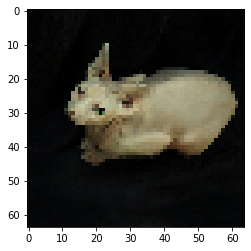

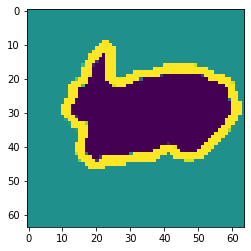

In [5]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(y_train[0].reshape((64, 64)))
plt.show()

Now let's see what the image looks like with a segmentation mask overlayed on top of it.

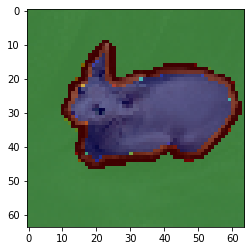

In [6]:
plt.imshow(x_train[0], cmap='gray')
plt.imshow(y_train[0].reshape((64, 64)), cmap='jet', alpha=0.5)
plt.show()

## **Understanding the Model**



---

Let's see how to build this model. All the following information and images come from [the paper](https://arxiv.org/pdf/1611.09326.pdf).

Let's start by understanding how the model works. It is comprised of a down-path (similar to an encoder), and an up-path (similar to a decoder). The general structure of the model is shown below. In the model, there are three main components - a "Dense Block," a "Transition Up" and a "Transition Down." The Dense Block is comprised of "Layers," which we will define later as well.

![General Architecture of Tiramisu Model](https://forums.fast.ai/uploads/default/original/2X/f/fc919345aa2105948ca50a55a43f7c5793b0e162.jpg)

As we can see, the left-side of the model is comprised of "Dense Blocks", followed by concatenation computations and then "Transition Down" computations. This cycle is repeated (keep in mind this is a very miniature version of the network, the actual one is much deeper. This is only for visualization). Take note of the skip connections between the down-path and the up-path.

The right side is comprised of a similar architecture, but reversed - it starts with a "Transition Up" computation, followed by a concatenation computation, and then a Dense Block. Conjoining the two is another Dense Block. The first and last layer are convolutions.

Let's see the structure of a Dense Block (note that this is a very small, 4-layer dense block. The ones we will use are much larger).

![alt text](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-20-at-3.42.24-PM.png)

As we can see, a Dense Block is comprised of multiple layers and concatenation computations. First, the input is run through a layer (which we will define later) - then, the output of this layer is concatenated to the input to this layer (the original input), and this value is then input into the next layer. The next concatenation computations takes this value (the input into this next layer) and the output of this next layer and concatenates them. This cycle is repeated over and over again, until the very last layer. The last concatenation computation is a concatenation of all of the layer's outputs in the Dense Block - this is then returned as the output.

Now let's see what this "Layer" inside a Dense Block, "Transition Up" and "Transition Down" are made of.

![](https://miro.medium.com/max/1970/1*1Pj56mTHPNha8Pg58fWJEQ.png)

This part is rather straightforward. As you can see above, the "Layer" used in our "Dense Block" is a computation comprised of batch normalization, a ReLU activation, 3x3 convolutions, and a dropout with a rate of 0.2.

The "Transition Down," only used in the down-path, is comprised of batch normalization, ReLU activation, a 1x1 convolution, a dropout with rate 0.2, and 2x2 maxpooling.

The "Transition Up," only used in the up-path, is comprised of a single 3x3 transposed convolution with a stride of 2. 

The full model architecture can be seen below.

![](https://forums.fast.ai/uploads/default/original/2X/c/c0e6b43494d60bb50b2d10f95505ee64fd3a09a0.png)

Here we can see all the elements from our diagram (note that `m` refers to the output dimensions). It is comprised of a 3x3 convolution, multiple layers of Dense Block + Transition Down groups (in our code, we will create a function for this called `db_td`), dense blocks, multiple layers of Transition Up + Dense Block (in our code, we will create a function for this called `tu_db`), and finally a 1x1 convolution with a softmax activation.

Now let's get into the code. We will start by making `layer`, `denseBlock`, `transitionUp`, and `transitionDown`, and then we will make higher-level functions to ease the model creation process.



## **Designing the Model**



---



First, let's create the `layer` function, as it will be used in `denseBlock`.

In [0]:
def layer(x, filters=16):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = keras.layers.Dropout(0.2)(x)
    return x

This code simply performs the operations mentioned above in keras.
Now let's create `denseBlock`.

In [0]:
def denseBlock(x, layers):
    blocks = []
    for i in range(layers-1):
        tmp = x
        x = layer(x, 16)
        blocks.append(x)
        x = keras.layers.concatenate([x, tmp])
    x = layer(x, 16)
    blocks.append(x)
    return keras.layers.concatenate(blocks)

This functions starts by initializing an empty array for us to store all of the outputs to `layer` (so we can concatenate them in the final output, as mentioned above). Then, we iterate through the layers (we use `layers-1` as the last layer does not use the same computation, it concatenates all the blocks instead of just the previous input). We store the input to the layer in a `tmp` variable, we append the output of the layer to the `blocks` list, and we concatenate the input (`tmp`) to the output (`x`). We continue this process until we get to the last layer - then, we also run the input through `layer` and add it to our `blocks` list, but our final output is just a concatenation of all the `layer` outputs.

Now let's create our `transitionDown` function.

In [0]:
def transitionDown(x, filters):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.MaxPool2D(padding='same')(x)
    return x

This code is also straight forward - it simply performs the operations mentioned when we described what it does in keras.

Finally, let's create our final building block - `transitionUp`.

In [0]:
def transitionUp(x, filters):
    x = keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same')(x)
    return x

This code performs the computations listed in the table in the previous section. Note the usage of `Conv2DTranspose` rather than `Conv2D`, as this is a transposed convolution, not just a convolution.

Now we will create our `db_td` and `tu_db` functions. These functions comprise the down-path and up-path. Feel free to refer to the first image in the previous section to recall what these sections of the model do.

In [0]:
def db_td(layers, x, m):
    tmp = x
    x = denseBlock(x, layers)
    x = keras.layers.concatenate([x, tmp])
    skipConnections.append(x)
    return transitionDown(x, m)

Here, we take the input and store it to `tmp`. We then perform a `denseBlock` computation for `layers` amount of layers, and concatenate its output with the `tmp` variable. We then append this output to a list of `skipConnections` to be used in the up-path. Finally, we return a `transitionDown` with an output dimensionality of `m`.

Now let's define `tu_db`.

In [0]:
def tu_db(layers, x, m, i):
    x = transitionUp(x, m)
    x = keras.layers.concatenate([x, skipConnections[::-1][i]])
    return denseBlock(x, layers)

This code takes the input and performs the `transitionUp` computation on it - then it adds the output of this with the corresponding `skipConnections` (`i` is a parameter passed that simply indicates the index of which item in `skipConnections` to choose - note that we reverse this list since what we added last is at the end). Then, we output a `denseBlock` computation for `layers` amount of layers.

Now we've finished with the building blocks of this model. We can go on to defining the broader architecture. This is now made very easy - we simply have to refer to the overall architecture of the model (last image in previous section), and use it here. This contains everything the table contains, including the output dimensionality (`m`). Here is the overall code.

In [0]:
skipConnections = []

inp = keras.layers.Input((size, size, 3))
x = keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same')(inp)
x = db_td(4, x, 112)
x = db_td(5, x, 192)
x = db_td(7, x, 304)
x = db_td(10, x, 464)
x = db_td(12, x, 656)
x = denseBlock(x, 15)
x = tu_db(12, x, 1088, 0)
x = tu_db(10, x, 816, 1)
x = tu_db(7, x, 578, 2)
x = tu_db(5, x, 384, 3)
x = tu_db(4, x, 256, 4)
x = keras.layers.Conv2D(3, kernel_size=(1, 1), activation='softmax')(x)
model = keras.models.Model(inputs=inp, outputs=x)

Note that our final convolution layer outputs for `3` classes, as it distinguishes between `{0, 1, 2}` for the different values of pixels.

## **Training the Model**



---


Now let's go on to compiling this model.


In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We will now train our model. We're going to use `tensorboard` to visualize the model's performance over time.

In [15]:
logDir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_cb = keras.callbacks.TensorBoard(logDir, histogram_freq=1)

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=64, shuffle=True, callbacks=[tf_cb])

Train on 3680 samples, validate on 3669 samples
Epoch 1/20
3680/3680 [==============================] - 71s 19ms/sample - loss: 0.9947 - accuracy: 0.5940 - val_loss: 0.8998 - val_accuracy: 0.5704
Epoch 2/20
3680/3680 [==============================] - 36s 10ms/sample - loss: 0.7692 - accuracy: 0.6535 - val_loss: 1.0369 - val_accuracy: 0.5731
Epoch 3/20
3680/3680 [==============================] - 36s 10ms/sample - loss: 0.6799 - accuracy: 0.7116 - val_loss: 0.9576 - val_accuracy: 0.5895
Epoch 4/20
3680/3680 [==============================] - 36s 10ms/sample - loss: 0.5964 - accuracy: 0.7549 - val_loss: 0.9391 - val_accuracy: 0.5970
Epoch 5/20
3680/3680 [==============================] - 36s 10ms/sample - loss: 0.5480 - accuracy: 0.7750 - val_loss: 0.9483 - val_accuracy: 0.5703
Epoch 6/20
3680/3680 [==============================] - 36s 10ms/sample - loss: 0.5049 - accuracy: 0.7933 - val_loss: 0.7964 - val_accuracy: 0.6563
Epoch 7/20
3680/3680 [==============================] - 36s 10ms

Let's visualize it in TensorBoard.

In [0]:
!tensorboard dev upload --logdir ./logs

As we can see, our loss went down and our accuracy converged (if we wanted to improve accuracy, we could train for more epochs, but in this tutorial we will keep it at 20).

## **Background Removal**


---

First, let's create a function that transforms our output mask, an array of probabilities, into a defined segmentation mask.

In [0]:
def create_mask(pred_mask):
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

This simply takes the `argmax` (highest value) of each array index.

Next, let's create a utility function to remove backgrounds. It checks whether the `mask` has a value of `0` (containing the pet) - if not, it turns the `image` pixel to white.

In [0]:
def create(image, mask):
  for i in range(size):
    for j in range(size):
      if mask[i][j] != 0:
        image[i][j][0] = 255
        image[i][j][1] = 255
        image[i][j][2] = 255
  return image

Now let's create a prediction function that takes an image as input and removes the background.

In [0]:
def predict(i):
  i = tf.image.resize(i, (64, 64))

  pred_mask = model.predict(tf.reshape(i, (1,64,64,3)))
  pred_mask = create_mask(pred_mask=pred_mask)

  removed = create(i.numpy(), pred_mask)
  plt.imshow(removed)
  plt.show()

Let's see how our model performs.

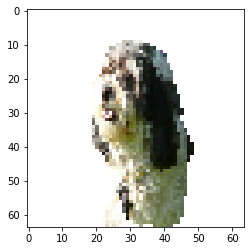

In [53]:
predict(x_test[24])

As we can see, although it is not perfect (this could be trained for much longer), our model gets the gist and is able to separate the pet from the background of the image.



---

### **References**

https://arxiv.org/pdf/1611.09326.pdf

https://www.tensorflow.org/tutorials/images/segmentation

**Images**

https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-20-at-3.42.24-PM.png

https://forums.fast.ai/uploads/default/original/2X/f/fc919345aa2105948ca50a55a43f7c5793b0e162.jpg

https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-20-at-3.42.24-PM.png

https://miro.medium.com/max/1970/1*1Pj56mTHPNha8Pg58fWJEQ.png

https://forums.fast.ai/uploads/default/original/2X/c/c0e6b43494d60bb50b2d10f95505ee64fd3a09a0.png
